# Permutation Feature Importance on "Who's Going to Leave Next?"

<a id='source_1'></a>
<a id='source_2'></a>

In this notebook example, we will explain the global behavior of a classification model by identifying the most important features it relies on. To obtain the importance of the features, we will use the `PermutationImportance` explainer, initially proposed by  [Breiman (2001)](https://link.springer.com/article/10.1023/A:1010933404324)[[1]](#References), and further refined by [Fisher et al. (2019)](https://arxiv.org/abs/1801.01489)[[2]](#References).

This notebook is inspired from the following [blogpost](https://lukesingham.com/whos-going-to-leave-next/).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

from alibi.explainers import PermutationImportance, plot_permutation_importance

### Read the dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ucg8j/kaggle_HR/master/HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


We will be using the `left` column as the target for the binary classification task. A value of 1 in the `left` column indicates that a person left the company.

In [3]:
# define target column
target_name = 'left'

# extract the features
feature_names = df.columns.to_list()
feature_names.remove(target_name)

# define categorical columns
categorical_names = [
    'Work_accident',           # binary
    'promotion_last_5years',   # binary
    'sales',                   # nominal
    'salary'                   # ordinal, but will treat it as nominal
]

# define numerical features
numerical_names = [ft for ft in feature_names if ft not in categorical_names]

Note that although the `salary` feature is ordinal, we will treat it as a nominal feature in this example.

### Data analysis

Before diving into the data preprocessing step and the actual model training, let us first explore the dataset. We begin by inspecting the proportion of positive and negative instances available in our dataset.

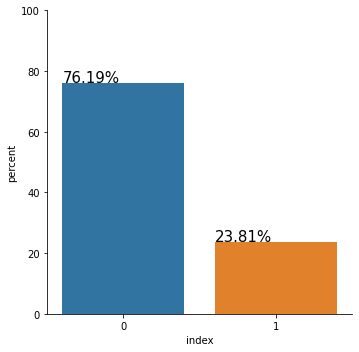

In [4]:
target_perc = df[target_name].value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(data=target_perc, x='index', y='percent', kind='bar')
g.ax.set_ylim(0, 100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x, txt_y = p.get_x(), p.get_height()
    g.ax.text(x=txt_x, y=txt_y, s=txt, fontdict={'size': 15})

Right away, we can observe that our dataset is quite imbalanced. The people who left the company are the minority class, representing only 23.81% of the entire dataset. Although this might not be the case for us, with extreme class imbalance, we should carefully consider which metric to use to evaluate the performance of our model.

For example, reporting the accuracy alone might not be sufficient. Consider, for example, the case in which we have 99% of the data instance belonging to the negative class and 1% belonging to the positive class - the class of interest. A classifier which predicts 0 every time will achieve an accuracy of 99%. Although the model achieves a high accuracy it is useless because it cannot detect any positive instances. Thus, in this scenario, better metrics to inspect the model performance are the precision, the recall, and the $F_1$ score. In addition, one can analyze the ROC-AUC curve to measure class separation.

Let us now inspect the relationship between each feature and the target. We begin by looking at the distribution of the numerical features grouped by labels.

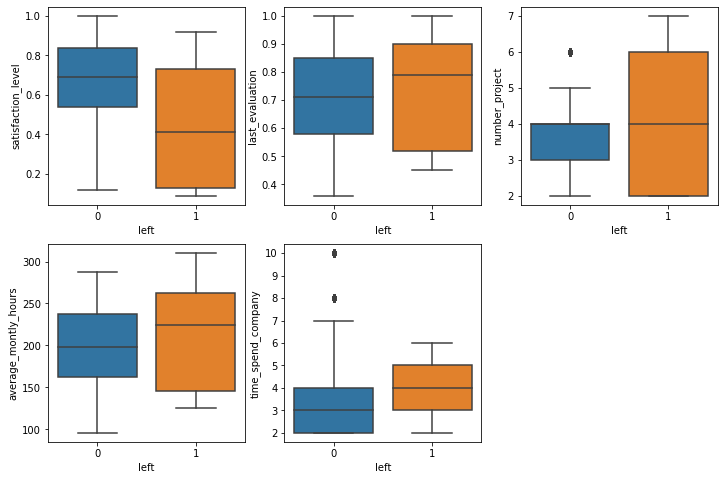

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.flatten()

for ax, ft in zip(axs, numerical_names):
    sns.boxplot(data=df, y=ft, x=target_name, ax=ax, orient='v')

fig.delaxes(axs[-1])

By inspecting the distributions above, we already see some associations. It is probably not surprising that people with lower satisfaction levels are more likely to leave. Similarly, people who work more hours and people that are older in the company have the same tendency to leave. All those associations make intuitive sense, and one can propose multiple plausible hypotheses on why this happens.

Quite interesting is that people who tend to have a higher evaluation score are also associated with leaving the company. Later, we will inspect the interactions between the two features, and we may be able to understand why this happens.

We now look at the categorical features.

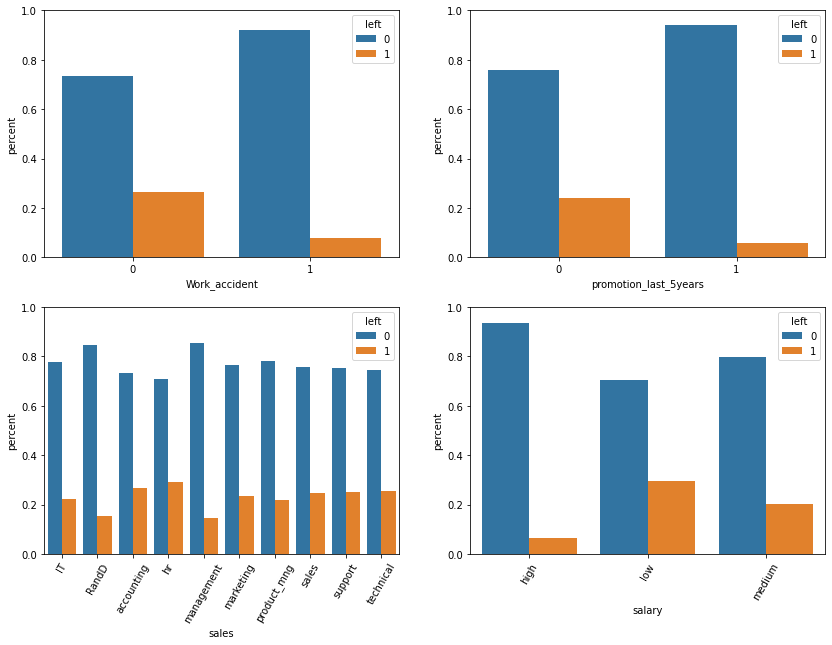

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for ax, ft in zip(axs, categorical_names):    
    ser1 = df.groupby([target_name, ft])[target_name].count()
    ser2 = df.groupby([ft])[target_name].count()
    df_prec = (ser1 / ser2).rename('percent').reset_index()
    sns.barplot(data=df_prec, x=ft, y='percent', hue=target_name, ax=ax)
    ax.set_ylim(0, 1)
    
axs[-2].tick_params(axis='x', rotation=60)
axs[-1].tick_params(axis='x', rotation=60)

We can eyeball some distribution that differ from the (76.19%, 23.81%):

In [7]:
prec = (df[df.Work_accident == 1].left == 0).mean() * 100
print("* Precentage of staying if a work accident happended: {:.2f}% > 76.19%\n".format(prec))

prec = (df[df.promotion_last_5years == 1].left == 0).mean() * 100
print("* Precentage of staying if a promotion happend in the last 5 years: {:.2f}% > 76.19%\n".format(prec))

prec = (df[df.sales == 'RandD'].left == 0).mean() * 100
print("* Precentage of staying if sales is RandD: {:.2f}% > 76.19%\n".format(prec))

prec = (df[df.sales == 'management'].left == 0).mean() * 100
print("* Precentage of staying if sales is management: {:.2f}% > 76.19%\n".format(prec))

prec = (df[df.salary == 'high'].left == 0).mean() * 100
print("* Precentage of staying if salary is high: {:.2f}% > 76.19%\n".format(prec))

prec = (df[df.sales == 'hr'].left == 1).mean() * 100
print("* Precentage of leaving if sales is hr: {:.2f}% > 23.81%".format(prec))

* Precentage of staying if a work accident happended: 92.21% > 76.19%

* Precentage of staying if a promotion happend in the last 5 years: 94.04% > 76.19%

* Precentage of staying if sales is RandD: 84.63% > 76.19%

* Precentage of staying if sales is management: 85.56% > 76.19%

* Precentage of staying if salary is high: 93.37% > 76.19%

* Precentage of leaving if sales is hr: 29.09% > 23.81%


We can observe from the above computation that people are more likely to stay if they had a work accident,  or they had a promotion in the last five years, or `sales` is `'RandD`' or is `'management'`, or their salary is high. Also, probably not as significant, we can observe a higher proportion than expected for people with `sales` equal `'hr'` to leave.


We continue our analysis by visualizing the interactions between two numerical features and their association with the target label.

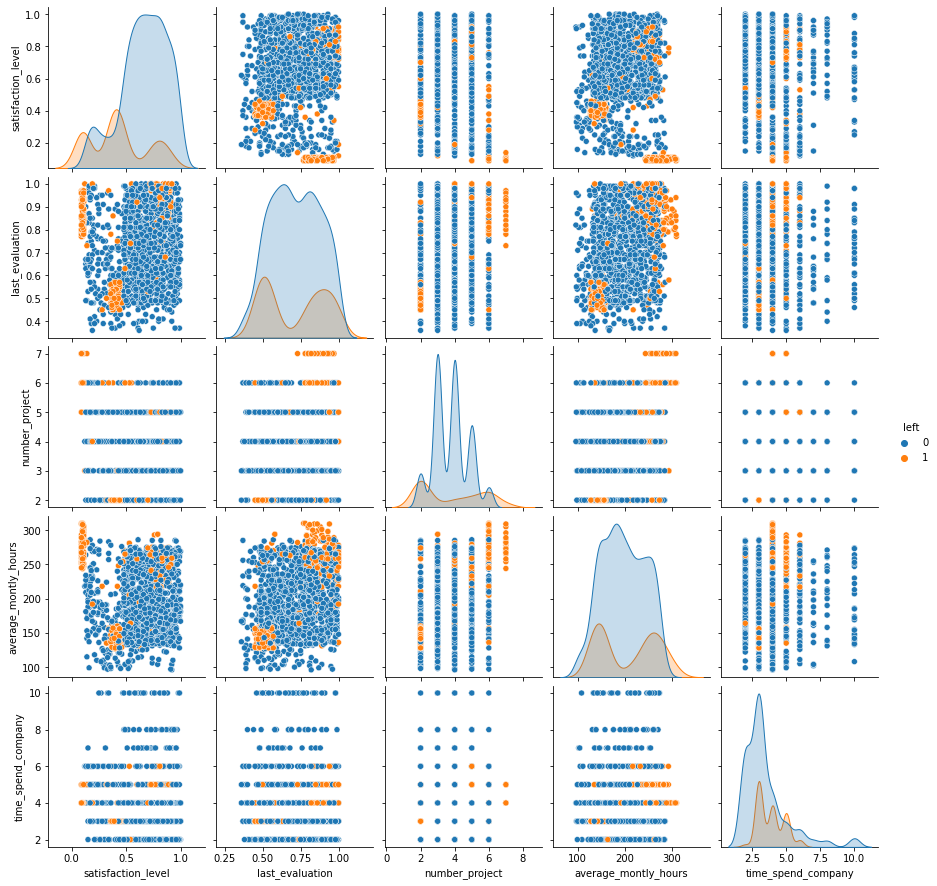

In [8]:
sns.pairplot(data=df.sample(frac=0.1), x_vars=numerical_names, y_vars=numerical_names, hue=target_name);

There are quite a few interactions that are worth mentioning:

* (`satisfaction_level`, `last_evaluation`) - We can observe three groups that tend to leave the company. We have people with a satisfaction level around 0.4 and the last evaluation around 0.5. Those are people who are not very happy with their job and are not that great at their tasks, and thus it makes intuitive sense to leave the company. We also have people with low satisfaction levels and high evaluation scores. Those might be very skillful people who can easily find other opportunities when they are not pleased anymore with their job. Finally, we have the satisfied people with high-performance evaluations representing the ones who enjoy and are very good at what they are doing but probably leave for better opportunities.


* (`satisfaction_level`, `average_montly_hours`) - Analogous to the previous case, we identify three groups (might coincide). The first group consists of people with a satisfaction level around 0.4 and who work on average a low number of hours per month. In the second group, we have people who work a lot, but are not very happy with their job. Finally, the third group is represented by satisfied people who work a lot.


* (`last_evaluation`, `number_project`) - we distinguish two groups. The first group consists of people with a low evaluation score and a low number of projects which might not be very productive for the company. The second group consists of people with a high evaluation score and a high number of projects.


* (`last_evaluation`, `average_montly_hours`) - Similarly, we can see two clear clusters defined by people with a low evaluation score and who work on average a low number of hours per month and people with a high evaluation score and large number monthly working hours.

Although there are many other interactions to mention, we stop here for the sake of this example. One can conduct similar investigations the categorical features. 

From the above analysis, we can conclude that numerical features are very relevant for the classification task.  

### Data preprocessing

We first split the dataset into train and test.

In [9]:
X = df[feature_names].to_numpy()
y = df[target_name].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Define and fit the preprocessor. We use only one hot encoding (OHE) for the categorical variables.

In [10]:
categorical_indices = [feature_names.index(ft) for ft in categorical_names]

# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[np.unique(X_train[:, ft_idx]) for ft_idx in categorical_indices],
    drop='if_binary'
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_indices)
    ],
    remainder='passthrough',
    sparse_threshold=0,
    
)

# fit the preprocessor
preprocessor = preprocessor.fit(X_train)

With the preprocessor fitted, we compute the OHE representation of the training and testing dataset.

In [11]:
# get OHE data representation
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

### Train  and evaluate random forest classifier

Now that we have the dataset in a good format, we are ready to train the `RandomForestClassifier` from the `sklearn` library

In [12]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0)
rf = rf.fit(X_train_ohe, y_train)

In [13]:
# evaluate classifier on train data
y_train_hat = rf.predict(X_train_ohe)
print(classification_report(y_true=y_train, y_pred=y_train_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999



In [14]:
# evaluate classifier on test data
y_test_hat = rf.predict(X_test_ohe)
print(classification_report(y_true=y_test, y_pred=y_test_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



As we can observe, our classifier performs reasonably well on all the metrics of interest.

### Permutation importance

With our classifier trained, we can perform post-hoc explanation to determine  which features are the most important for our model. We begin by defining prediction function followed by the initialization of the `alibi` explainer. Note that `alibi` supports some metric functions which can be specified through strings.

In [15]:
def predict_fn(X: np.ndarray):
    return rf.predict(preprocessor.transform(X))

In [16]:
explainer = PermutationImportance(predictor=predict_fn,
                                  score_fns=['accuracy', 'f1'],
                                  feature_names=feature_names,
                                  verbose=True)

We are now ready to compute the global importance of the features. If the list of features is not provided, by default the explainer will compute the importance of all the features in the dataset. Also, by default the explainer uses the estimation method to compute the feature importance because it is less computationally intensive, and the importance returned is the ratio between the original score and the permuted score.

In [17]:
exp = explainer.explain(X=X_test, y=y_test)

100%|██████████| 9/9 [00:14<00:00,  1.61s/it]


To inspect the results, we can use the built-in `plot_permutation_importance` function.

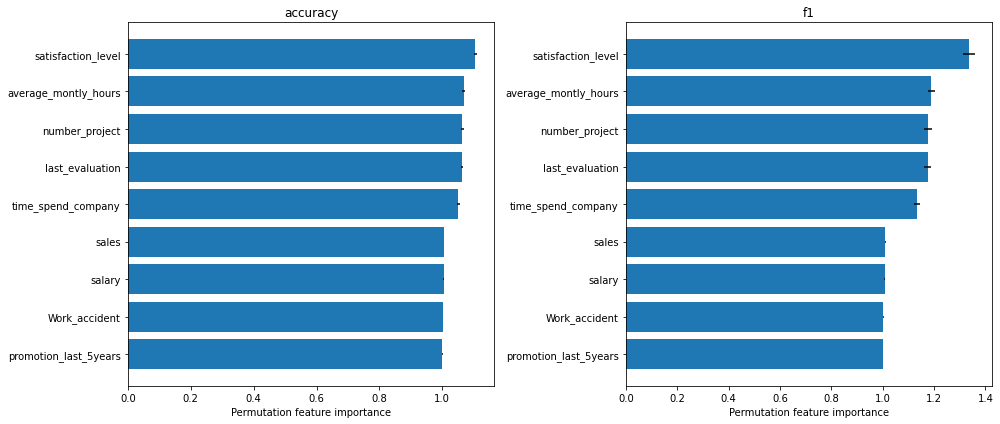

In [18]:
plot_permutation_importance(exp,
                            n_cols=2,
                            fig_kw={'figwidth': 14, 'figheight': 6});

From the $F_1$ score plot, we can see that the most important feature that the model relies on is the `satisfaction level`. Following that, we have three features that have approximately the same importance, namely the `average_montly_hours`, `last_evaluation` and `number_project`. Finally, in our top 5 hierarchy we have `time_spend_company`.

We can observe that features like `sales`, `salary`, `Work_accident` and `promotion_last_5years` receive an importance of 1, which in our case since it means that they are not relevant for the model (i.e., we are using the ratio between the base and permuted score and a ratio close to 1 means that the original score and the permuted score are approximately the same).

Note that we observe the same ordering in the `accuracy` plot. It is worth emphasizing that although this might happen in this particular case, it is not true in general. Using different loss function can yield different results.

### Custom metrics

We can also use custom score and loss functions apart from the ones already provided. For example, if we would like to use `1 - f1` metric, we need to define the corresponding loss function. To change the metric functions, we need to define a new explainer and ensure that the output of the predictor is compatible with the loss function.

In [19]:
def loss_f1(y_true: np.ndarray, y_pred: np.ndarray):
    return 1 - f1_score(y_true=y_true, y_pred=y_pred)

In [20]:
explainer_loss_f1 = PermutationImportance(predictor=predict_fn,
                                          loss_fns={'1 - f1': loss_f1},
                                          feature_names=feature_names,
                                          verbose=True)

In [21]:
exp_loss_f1 = explainer_loss_f1.explain(X=X_test, y=y_test)

100%|██████████| 9/9 [00:15<00:00,  1.69s/it]


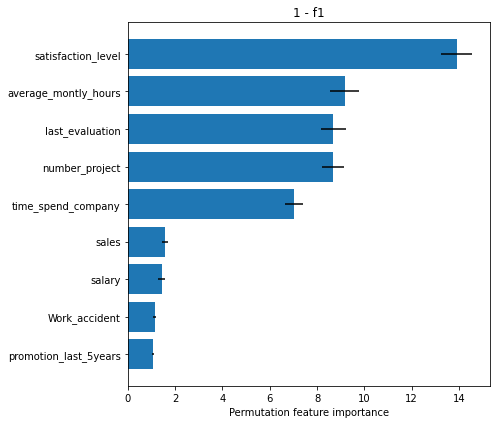

In [22]:
plot_permutation_importance(exp=exp_loss_f1,
                            fig_kw={'figwidth': 7, 'figheight': 6});

As another example, if we want to use the `1 - auc` metric we need to define the corresponding loss function, a new predictor which returns the probability of the positive class instead of the label, and implicitly will require to define a new explainer. Note that we need to define e new predictor because the output of the predictor must be compatible with the arguments expected by the loss function.

In [23]:
def loss_auc(y_true: np.ndarray, y_score: np.ndarray):
    return 1 - roc_auc_score(y_true=y_true, y_score=y_score)

def proba_fn(X: np.ndarray):
    return rf.predict_proba(preprocessor.transform(X))[:, 1]

In [24]:
explainer_loss_auc = PermutationImportance(predictor=proba_fn,
                                           loss_fns={'1 - auc': loss_auc},
                                           feature_names=feature_names,
                                           verbose=True)

In [25]:
exp_loss_auc = explainer_loss_auc.explain(X=X_test, y=y_test)

100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


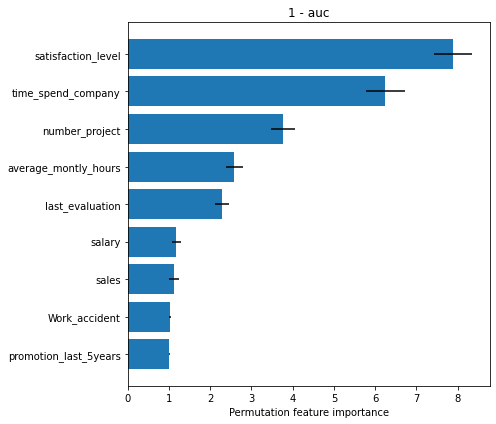

In [26]:
plot_permutation_importance(exp=exp_loss_auc,
                            fig_kw={'figwidth': 7, 'figheight': 6});

To conclude, we can observe from the plots above, that the numerical features are quite important for the classification task which agrees with the intuition we developed in our data analysis step. Note that based on the metric used, the importance of the features, and implicitly their ordering can differ. Nevertheless, we observe that the `satisfaction_level` feature is consistently reported as the most important.

## References

<a id='References'></a>

[[1]](#source_1) Breiman, Leo. "Random forests." Machine learning 45.1 (2001): 5-32.

[[2]](#source_2) Fisher, Aaron, Cynthia Rudin, and Francesca Dominici. "All Models are Wrong, but Many are Useful: Learning a Variable's Importance by Studying an Entire Class of Prediction Models Simultaneously." J. Mach. Learn. Res. 20.177 (2019): 1-81.